In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import sem
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.ticker as mticker  # Import the necessary module
from matplotlib.ticker import FuncFormatter


In [2]:
## set up file list & subject list ##
# several versions of the task are run. To pull subjects of interest, get information from this file
pinfo = pd.read_csv('/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/participants.csv')
subgroup = pinfo.loc[(pinfo['exp_version ']== 'non-contextual_quiz_after_repetition'), ['subject id', 'quiz_feedback', 'paradigm_version']]
dlist = ["/Users/sdiaw/Library/CloudStorage/Box-Box/iEEG_MAZE_project/DATA/BEHAVIOR/patient cohort/all patient data/{}".format(subj) for subj in list(subgroup['subject id'])]
savepath = ['/Users/sdiaw/Documents/MazeStudy/behavioral/behavior analysis/analysis/']

subgroup

,subject id,quiz_feedback,paradigm_version
0,DA17,0,2023_1_23
1,DA18,0,2023_1_23
2,DA19_1,0,2023_1_23
3,DA19_2,0,2023_1_23
4,DA22,0,2023_3_17
5,DA23,0,2023_3_17
6,IR103,0,2023_3_17
7,DA30,0,2023_3_17


In [3]:
# ## set up file list & subject list - FOR COLLEGE COHORT ##
# # several versions of the task are run. To pull subjects of interest, get information from this file
# pinfo = pd.read_csv('/Users/sdiaw/Library/CloudStorage/Box-Box/MAZE_project/DATA/BEHAVIOR/college cohort/participants.csv')
# subgroup = pinfo.loc[(pinfo['paradigm_version']== '2022'), ['subject id', 'quiz_feedback', 'paradigm_version']]
# dlist = ["/Users/sdiaw/Library/CloudStorage/Box-Box/MAZE_project/DATA/BEHAVIOR/college cohort/all subj data/{}".format(subj) for subj in list(subgroup['subject id'])]
# savepath = ['/Users/sdiaw/Documents/MazeStudy/behavioral/behavior analysis/analysis/']

# subgroup

In [4]:
trimRT = False
# helper functions
from scipy.spatial import distance

def get_goal_loc(df):
    goal_locations = df.loc[(df.task == 'nav') & (df.block_type == 'E') & (df.block%3 == 1), ['maze_ID', 'coordinate']]
    goal_locations = goal_locations.sort_values(by ='maze_ID')
    return goal_locations

def get_goal_loc_4th_block(df):
    goal_locations = df.loc[(df.task == 'nav') & (df.block_type == 'E') & (df.block == 10), ['maze_ID', 'coordinate']]
    goal_locations = goal_locations.sort_values(by ='maze_ID')
    return goal_locations

def get_nav_sq_rt(df):
    m = df.groupby('block_type').rt.mean()
    m = m.to_frame().transpose()
    return m

def convert_coord_int(coord_str):
    foo = str.strip(coord_str, '()').split(',')
    x, y = [int(str.rstrip(foo[i], '.0')) for i in range(0,len(foo))]
    return x,  y

# group data based on blocks and repetition (only 3 mazesets)

In [5]:
# compute/extract additional metrics for individual data & generate group summary
# initiate a dataframe for group summary
group_df = pd.DataFrame()
group_subjs = []
group_feedback = []

# initiate a dataframe for maze summary
maze_df = pd.DataFrame()
maze_blocks = list(range(0, 3, 1))
maze_reps = list(range(0, 3, 1))
maze_rtD = []
maze_rtX = []
maze_rtN = []
maze_rtG = []
maze_rtZ = []
maze_DT = []
maze_qdist = []
maze_subj = []
maze_id = []
maze_block = []
maze_rep = []
maze_sgrp = []
maze_para_ver = []

for subjdir in dlist:
    # extract subject-specific information to be added in the group summary
    subjstr = subjdir.split('/')[-1]
    grp_idx = subgroup.loc[subgroup['subject id'] == subjdir.split('/')[-1]].iloc[0]['quiz_feedback']
    paradigm_ver = subgroup.loc[subgroup['subject id'] == subjdir.split('/')[-1]]['paradigm_version'].iloc[0]
    group_feedback.append(grp_idx)
    group_subjs.append(subjstr)
    data = pd.read_csv(subjdir+'/'+ subjdir.split('/')[-1] +'_maze_log.csv') # read in participant data

    ################### START: adding to individual data ###################
    # adding to individual data1: Quiz accuracy [correctness and distance] & Distance Traveled in that maze
    df_goal_coord = get_goal_loc(data) # get a df of maze id & goal coordinates
    a = []
    d = []
    dt = []
    for row in range(len(data)):
        if 'quiz_click' in data.task.iloc[row]:
            answer_coord = data.iloc[row].coordinate
            goal_coord = df_goal_coord.coordinate.loc[(df_goal_coord.maze_ID == data.iloc[row].maze_ID)].values[0]
            x_a, y_a  = convert_coord_int(answer_coord)
            x_g, y_g  = convert_coord_int(goal_coord)
            d.append(distance.euclidean([x_a, y_a], [x_g, y_g]))
            if answer_coord == goal_coord:
                a.append(1)
            else:
                a.append(0)
        else:
            a.append(np.nan)
            d.append(np.nan)
        dt.append(data.loc[(data.task == 'nav') & (data.block == data.block.iloc[row]) & (data.maze_ID == data.maze_ID.iloc[row])].shape[0])
    data['quiz_acc'] = a
    data['quiz_dist'] = d
    data['dist_traveled'] = dt

    # adding to individual data2: Repetition variable [dummy value 4 for non-contextual quiz]
    data['repetition'] = data.apply(lambda row: (row.block-1)%3, axis = 1)
    def condition(x):
        if x==1 or x==2 or x==3 :
            return 0
        elif x==4 or x==5 or x==6 :
            return 1
        elif x==7 or x==8 or x==9 :
            return 2
        elif x==10 or x==11 or x==12 :
            return 3
    
    # Applying the conditions   
    data['block_summary'] = data['block'].apply(condition)
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 3), 'block_summary'] = 3
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 3), 'repetition'] = 3
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 6), 'block_summary'] = 4
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 6), 'repetition'] = 4
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 9), 'block_summary'] = 5
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 9), 'repetition'] = 5
    if 12 in data['block']:
        data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 12), 'block_summary'] = 6
        data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 12), 'repetition'] = 6
    data.to_csv(savepath[0]+subjstr+'.csv', index = False)
    ################### START: adding subject row to group summary ###################
    # subject-level summary measure 1: navigation - mean RT at each square type
    df_nav = data.loc[data['task'] == 'nav'] # pull out navigation and quiz portion into separate dataframes
    if trimRT:
        df_nav = df_nav[~(np.abs(df_nav.rt-df_nav.rt.mean()) > (3*df_nav.rt.std()))] # remove RT outliers
    cname = ['rt' + c for c in get_nav_sq_rt(df_nav).columns.tolist()]
    srow_df = pd.DataFrame([get_nav_sq_rt(df_nav).values[0].tolist()], columns = cname)

    # subject-level summary measure 2: quiz - mean accuracy and distnace
    acc = []
    dist = []
    nav_dist = []
    type = 'contextual_quiz_click'
    acc.append(data.loc[(data.task == type),'quiz_acc'].mean())
    for block in [0, 1, 2]:
        for rep in [0, 1, 2]:
            acc.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'quiz_acc'].mean())
            dist.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'quiz_dist'].mean())
            #nav_dist.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'dist_traveled'].mean())
    type = 'non_contextual_quiz_click'
    for block in [3, 4, 5]:
        acc.append(data.loc[(data.task == type) & (data.block_summary == block),'quiz_acc'].mean())
        dist.append(data.loc[(data.task == type) & (data.block_summary == block),'quiz_dist'].mean())

    srow_df = pd.concat([srow_df, pd.DataFrame([acc+dist], columns = ['overall_context_acc', 'acc_context_1' ,'acc_context_2', 'acc_context_3', 'acc_context_4','acc_context_5', 'acc_context_6', 'acc_context_7', 'acc_context_8', 'acc_context_9', 'acc_noncontext_1', 'acc_noncontext_2','acc_noncontext_3','dist_context_1','dist_context_2','dist_context_3','dist_context_4','dist_context_5','dist_context_6','dist_context_7','dist_context_8','dist_context_9','dist_noncontext_1','dist_noncontext_2','dist_noncontext_3'])], axis = 1) # 'navdist_0', 'navdist_1', 'navdist_2'
    group_df = pd.concat([group_df, srow_df], axis = 0, ignore_index = True)

    ################### END: adding subject row to group summary ###################
    for block in maze_blocks:
        maze_id_list = data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block), 'maze_ID'].values[0:8]
        for rep in maze_reps:
            for maze in maze_id_list:       
                maze_rtD.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'D'), 'rt'].mean())
                maze_rtX.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'X'), 'rt'].mean())
                maze_rtN.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'N'), 'rt'].mean())
                maze_rtG.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'G'), 'rt'].mean())
                maze_rtZ.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'Z'), 'rt'].mean())
                maze_DT.append(data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze), 'dist_traveled'].values[0])
                maze_qdist.append(data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze), 'quiz_dist'].values[0])
                maze_subj.append(subjstr)
                maze_id.append(maze)
                maze_block.append(block)
                maze_rep.append(rep)
                maze_sgrp.append(grp_idx)
                maze_para_ver.append(paradigm_ver)
    nDT = []
    tmp_df = pd.DataFrame(list(zip(maze_DT,maze_id)), columns = ['DT', 'ID'])
    for row in range(len(tmp_df)):
        nDT.append(tmp_df.DT.iloc[row] - tmp_df.DT.loc[tmp_df.ID == tmp_df.ID.iloc[row]].mean())
    maze_df = pd.concat([maze_df, pd.DataFrame(list(zip(maze_subj, maze_sgrp, maze_para_ver, maze_id, maze_block, maze_rep, maze_rtD, maze_rtX, maze_rtN, maze_rtG, maze_rtZ, maze_DT, nDT, maze_qdist)),
                  columns=['subj','fb_group', 'maze_paradigm_version','maze_id', 'block_summary', 'repetition', 'rtD', 'rtX', 'rtN', 'rtG', 'rtZ','dist_traveled', 'mcDT', 'quiz_dist'])], axis = 0, ignore_index = True)
    # re-initialize for the next subj data
    maze_rtD = []
    maze_rtX = []
    maze_rtN = []
    maze_rtG = []
    maze_rtZ = []
    maze_DT = []
    maze_qdist = []
    maze_subj = []
    maze_id = []
    maze_block = []
    maze_rep = []
    maze_sgrp = []
    maze_para_ver = []

group_df.insert(0, 'id', group_subjs)
group_df.insert(1, 'fb_group', group_feedback)


# Plotting Quiz Accuracy Across Blocks for Each Participant

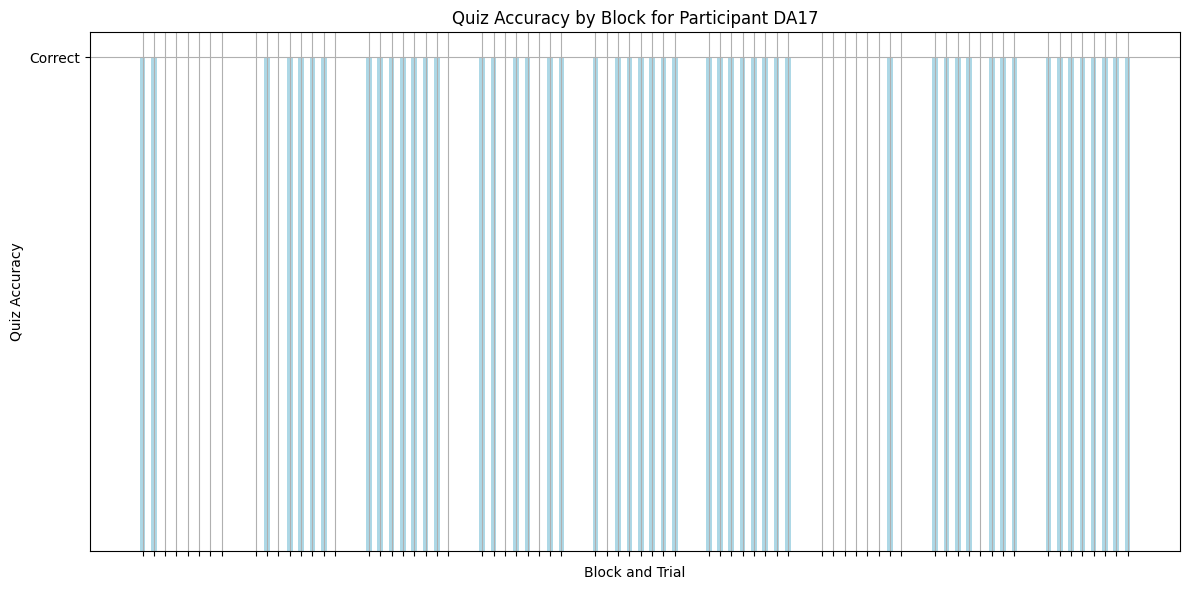

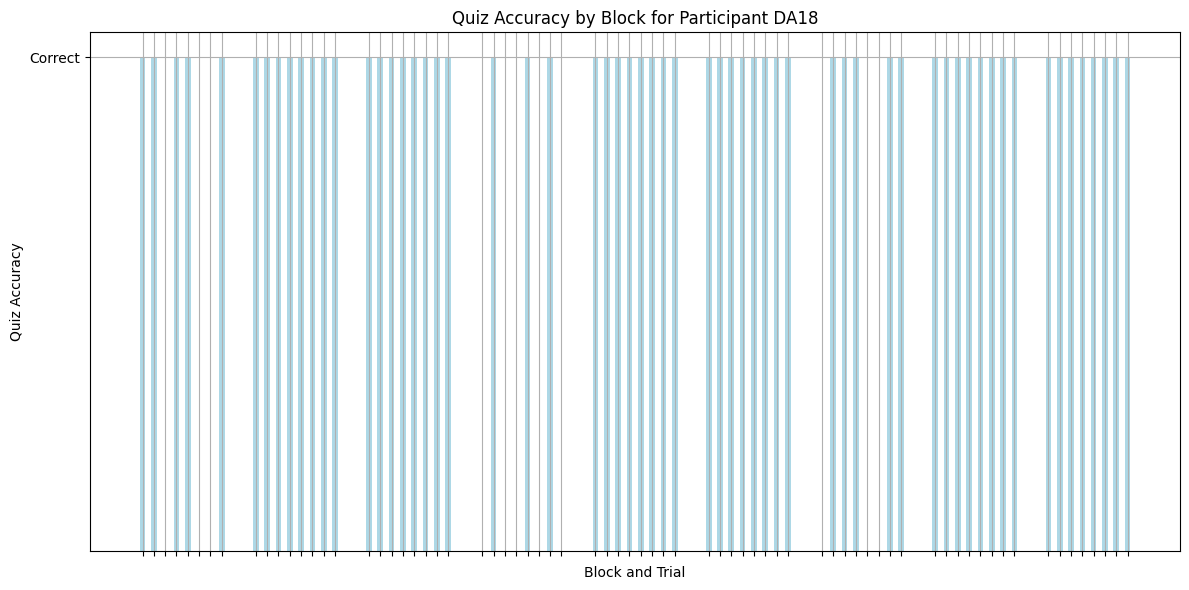

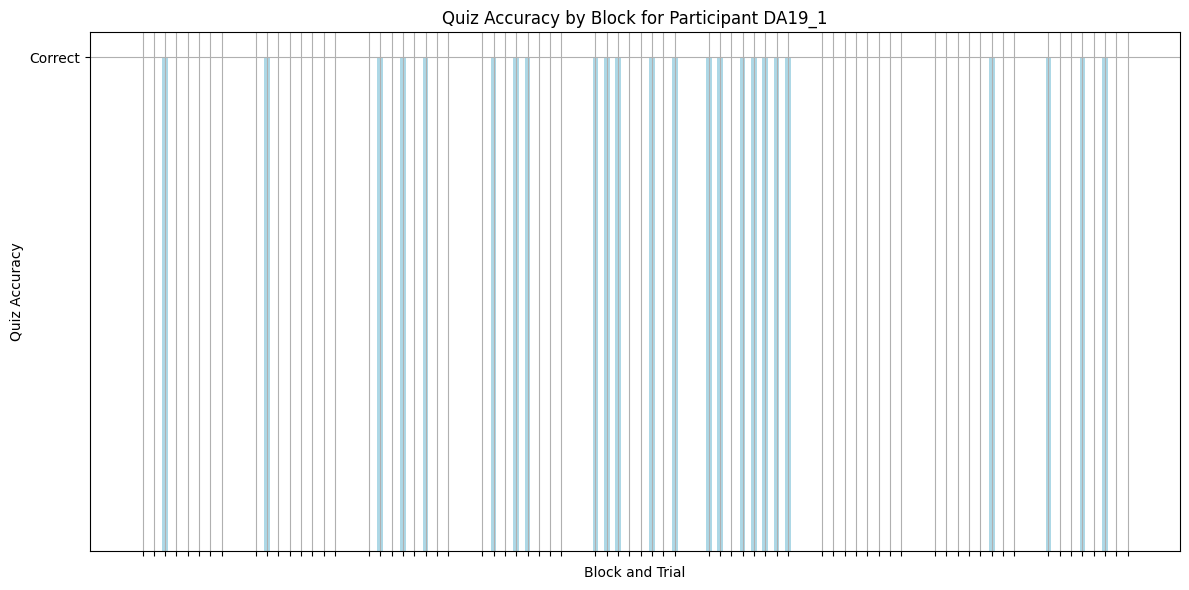

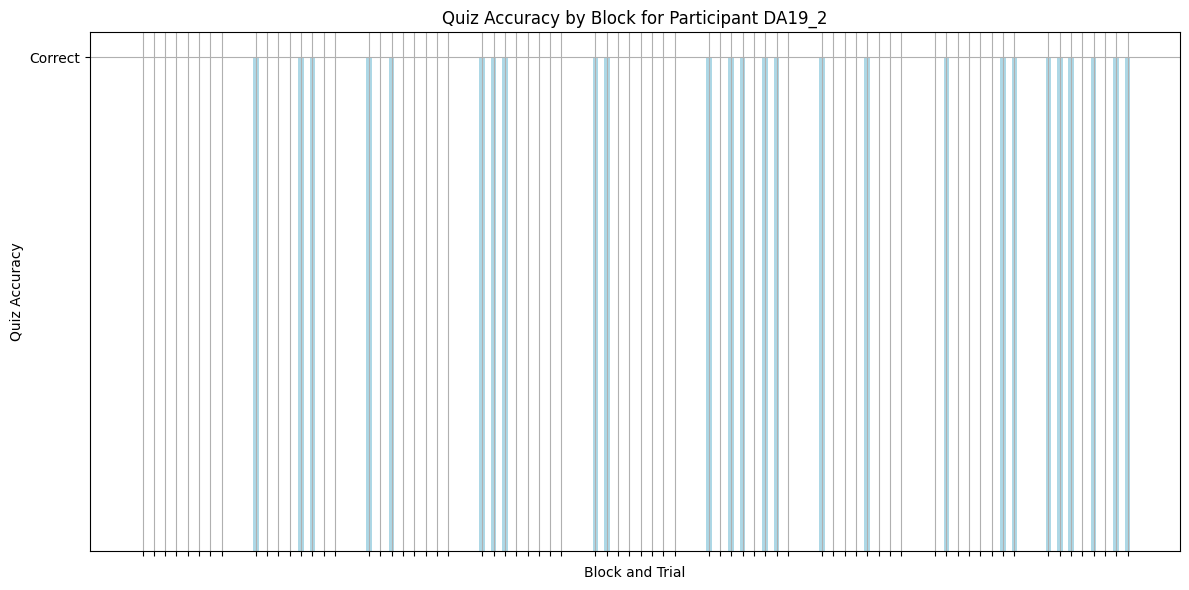

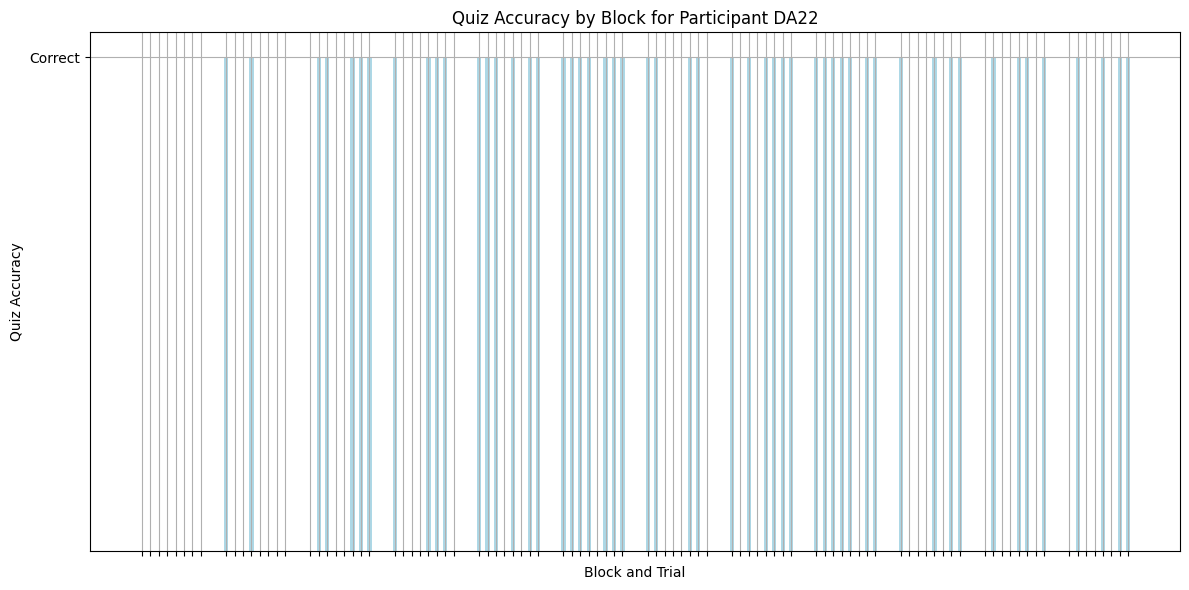

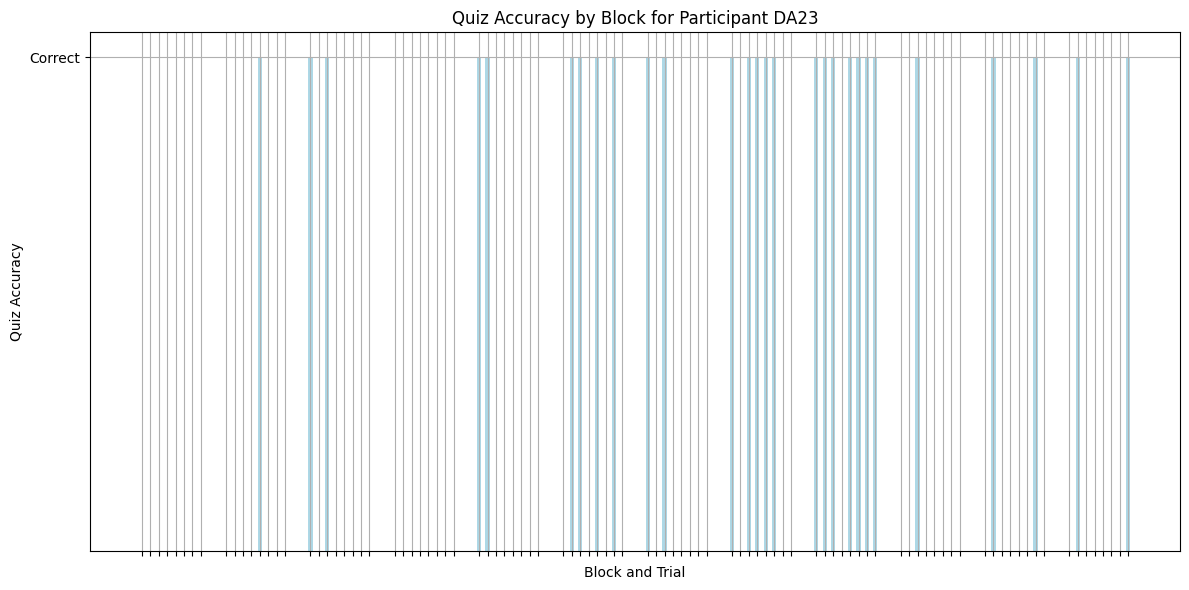

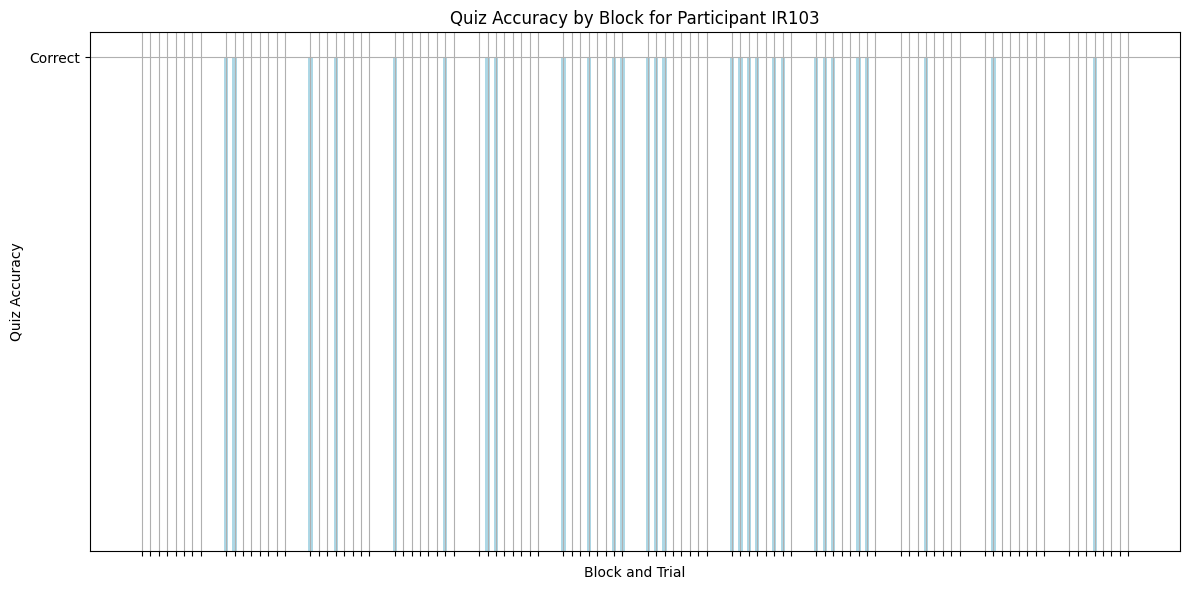

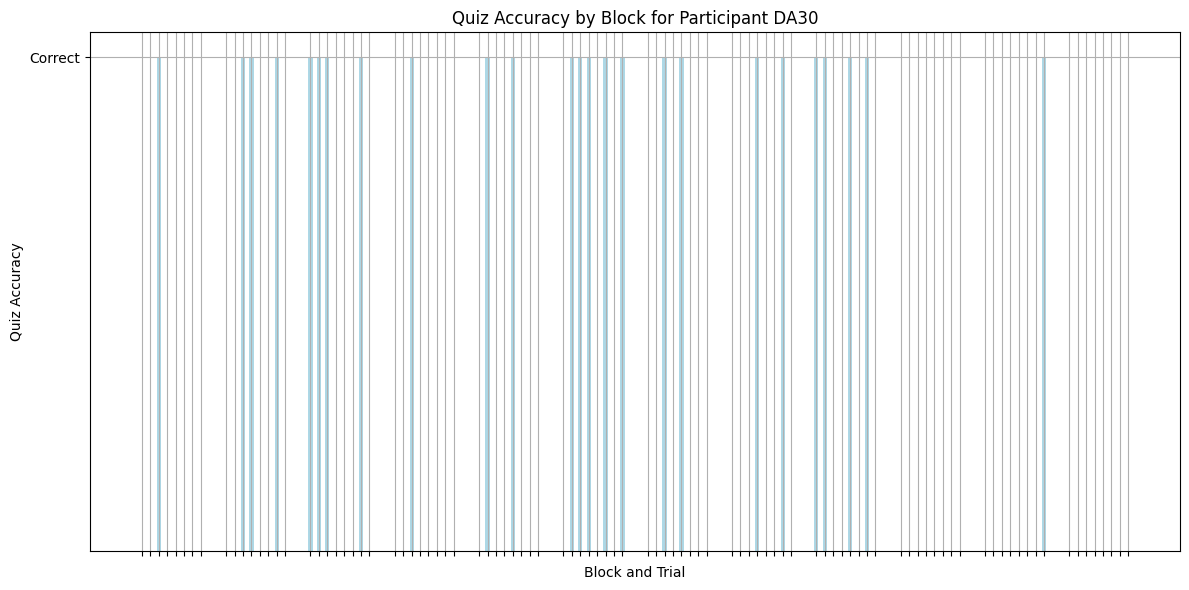

In [6]:
participant_files = []

for subjdir in dlist:
    # extract subject-specific information to be added in the group summary
    subjstr = subjdir.split('/')[-1]
    filepath = f'/Users/sdiaw/Documents/MazeStudy/behavioral/behavior analysis/analysis/{subjstr}.csv'
    participant_files.append(filepath)


# Create an empty list to hold the DataFrames
data_frames = []

# Loop through participant files and load data into DataFrames
for file_path in participant_files:
    participant_id = file_path.split("/")[-1].split(".")[0]  # Extract ID from the file path
    participant_data = pd.read_csv(file_path)
    participant_data['participant'] = participant_id
    data_frames.append(participant_data)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(data_frames, ignore_index=True)

# Filter data for rows where the task column is equal to 'contextual_quiz_click'
quiz_data = all_data[all_data['task'] == 'contextual_quiz_click']

# Set up a separate graph for each participant
participants = quiz_data['participant'].unique()
for participant in participants:
    plt.figure(figsize=(12, 6))
    plt.title(f"Quiz Accuracy by Block for Participant {participant}")
    plt.xlabel("Block and Trial")
    plt.ylabel("Quiz Accuracy")
    plt.yticks([1], ['Correct'])

    participant_data = quiz_data[quiz_data['participant'] == participant]

    # Calculate the x-values for each bar with space between blocks
    x_values = []
    x_labels = []
    block_counter = 1
    for index, row in participant_data.iterrows():
        x_value = (block_counter * 10) + row['trial']  # Assuming 8 trials per block
        x_values.append(x_value)
        if row['trial'] == 8:  # Move to the next block after 8 trials
            block_counter += 1

    plt.bar(x_values, participant_data['quiz_acc'], color='lightblue', width=0.5)  # Adjust width for spacing

    plt.xticks(x_values, x_labels, rotation=45, ha="right")

    plt.grid(True)
    plt.tight_layout()

    # Save or show the plot
    plt.savefig(f"participant_{participant}_quiz_accuracy.png")
    plt.show()  # Uncomment if you want to display the plots interactively
    plt.close()

In [7]:
maze_df.to_csv('patient_data_summary.csv', index=False)

# group data based on blocks and repetitions (4 mazesets)

In [8]:
# compute/extract additional metrics for individual data & generate group summary
# initiate a dataframe for group summary
group_df = pd.DataFrame()
group_subjs = []
group_feedback = []

# initiate a dataframe for maze summary
maze_df = pd.DataFrame()
maze_blocks = list(range(0, 4, 1))
maze_reps = list(range(0, 3, 1))
maze_rtD = []
maze_rtX = []
maze_rtN = []
maze_rtG = []
maze_rtZ = []
maze_DT = []
maze_qdist = []
maze_subj = []
maze_id = []
maze_block = []
maze_rep = []
maze_sgrp = []
maze_para_ver = []

for subjdir in dlist:
    # extract subject-specific information to be added in the group summary
    subjstr = subjdir.split('/')[-1]
    grp_idx = subgroup.loc[subgroup['subject id'] == subjdir.split('/')[-1]].iloc[0]['quiz_feedback']
    paradigm_ver = subgroup.loc[subgroup['subject id'] == subjdir.split('/')[-1]]['paradigm_version'].iloc[0]
    group_feedback.append(grp_idx)
    group_subjs.append(subjstr)
    data = pd.read_csv(subjdir+'/'+ subjdir.split('/')[-1] +'_maze_log.csv') # read in participant data

    ################### START: adding to individual data ###################
    # adding to individual data1: Quiz accuracy [correctness and distance] & Distance Traveled in that maze
    df_goal_coord = get_goal_loc(data) # get a df of maze id & goal coordinates
    df_goal_coord_4th_block = get_goal_loc_4th_block(data)
    a = []
    d = []
    dt = []
    for row in range(len(data)):
        if 'quiz_click' in data.task.iloc[row]:
            answer_coord = data.iloc[row].coordinate
            if data.iloc[row].block <= 9:
                goal_coord = df_goal_coord.coordinate.loc[(df_goal_coord.maze_ID == data.iloc[row].maze_ID)].values[0]
            elif data.iloc[row].block >= 10:
                goal_coord = df_goal_coord_4th_block.coordinate.loc[(df_goal_coord.maze_ID == data.iloc[row].maze_ID)].values[0]
            x_a, y_a  = convert_coord_int(answer_coord)
            x_g, y_g  = convert_coord_int(goal_coord)
            d.append(distance.euclidean([x_a, y_a], [x_g, y_g]))
            if answer_coord == goal_coord:
                a.append(1)
            else:
                a.append(0)
        else:
            a.append(np.nan)
            d.append(np.nan)
        dt.append(data.loc[(data.task == 'nav') & (data.block == data.block.iloc[row]) & (data.maze_ID == data.maze_ID.iloc[row])].shape[0])
    data['quiz_acc'] = a
    data['quiz_dist'] = d
    data['dist_traveled'] = dt

    # adding to individual data2: Repetition variable [dummy value 4 for non-contextual quiz]
    data['repetition'] = data.apply(lambda row: (row.block-1)%3, axis = 1)
    def condition(x):
        if x==1 or x==2 or x==3 :
            return 0
        elif x==4 or x==5 or x==6 :
            return 1
        elif x==7 or x==8 or x==9 :
            return 2
        elif x==10 or x==11 or x==12 :
            return 3
    
    # Applying the conditions   
    data['block_summary'] = data['block'].apply(condition)
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 3), 'block_summary'] = 3
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 3), 'repetition'] = 3
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 6), 'block_summary'] = 4
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 6), 'repetition'] = 4
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 9), 'block_summary'] = 5
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 9), 'repetition'] = 5
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 12), 'block_summary'] = 6
    data.loc[(data.task == 'non_contextual_quiz_click') & (data['block'] == 12), 'repetition'] = 6
    data.to_csv(savepath[0]+subjstr+'.csv', index = False)
    ################### START: adding subject row to group summary ###################
    # subject-level summary measure 1: navigation - mean RT at each square type
    df_nav = data.loc[data['task'] == 'nav'] # pull out navigation and quiz portion into separate dataframes
    if trimRT:
        df_nav = df_nav[~(np.abs(df_nav.rt-df_nav.rt.mean()) > (3*df_nav.rt.std()))] # remove RT outliers
    cname = ['rt' + c for c in get_nav_sq_rt(df_nav).columns.tolist()]
    srow_df = pd.DataFrame([get_nav_sq_rt(df_nav).values[0].tolist()], columns = cname)

    # subject-level summary measure 2: quiz - mean accuracy and distnace
    acc = []
    dist = []
    nav_dist = []
    type = 'contextual_quiz_click'
    acc.append(data.loc[(data.task == type),'quiz_acc'].mean())
    for block in [0, 1, 2, 3]:
        for rep in [0, 1, 2]:
            acc.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'quiz_acc'].mean())
            dist.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'quiz_dist'].mean())
            #nav_dist.append(data.loc[(data.task == type) & (data.block_summary == block) & (data.repetition == rep),'dist_traveled'].mean())
    type = 'non_contextual_quiz_click'
    for block in [3, 4, 5, 6]:
        acc.append(data.loc[(data.task == type) & (data.block_summary == block),'quiz_acc'].mean())
        dist.append(data.loc[(data.task == type) & (data.block_summary == block),'quiz_dist'].mean())

    srow_df = pd.concat([srow_df, pd.DataFrame([acc+dist], columns = ['overall_context_acc', 'acc_context_1' ,'acc_context_2', 'acc_context_3', 'acc_context_4','acc_context_5', 'acc_context_6', 'acc_context_7', 'acc_context_8', 'acc_context_9', 'acc_context_10','acc_context_11','acc_context_12','acc_noncontext_1', 'acc_noncontext_2','acc_noncontext_3','acc_noncontext_4','dist_context_1','dist_context_2','dist_context_3','dist_context_4','dist_context_5','dist_context_6','dist_context_7','dist_context_8','dist_context_9','dist_context_10','dist_context_11','dist_context_12','dist_noncontext_1','dist_noncontext_2','dist_noncontext_3','dist_noncontext_4'])], axis = 1) # 'navdist_0', 'navdist_1', 'navdist_2'
    group_df = pd.concat([group_df, srow_df], axis = 0, ignore_index = True)

    ################### END: adding subject row to group summary ###################
    for block in maze_blocks:
        maze_id_list = data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block), 'maze_ID'].values[0:8]
        for rep in maze_reps:
            for maze in maze_id_list:       
                maze_rtD.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'D'), 'rt'].mean())
                maze_rtX.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'X'), 'rt'].mean())
                maze_rtN.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'N'), 'rt'].mean())
                maze_rtG.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'G'), 'rt'].mean())
                maze_rtZ.append(data.loc[(data.task == 'nav') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze) & (data.block_type == 'Z'), 'rt'].mean())
                maze_DT.append(data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze), 'dist_traveled'].values[0])
                maze_qdist.append(data.loc[(data.task == 'contextual_quiz_click') & (data.block_summary ==block) & (data.repetition == rep) & (data.maze_ID == maze), 'quiz_dist'].values[0])
                maze_subj.append(subjstr)
                maze_id.append(maze)
                maze_block.append(block)
                maze_rep.append(rep)
                maze_sgrp.append(grp_idx)
                maze_para_ver.append(paradigm_ver)
    nDT = []
    tmp_df = pd.DataFrame(list(zip(maze_DT,maze_id)), columns = ['DT', 'ID'])
    for row in range(len(tmp_df)):
        nDT.append(tmp_df.DT.iloc[row] - tmp_df.DT.loc[tmp_df.ID == tmp_df.ID.iloc[row]].mean())
    maze_df = pd.concat([maze_df, pd.DataFrame(list(zip(maze_subj, maze_sgrp, maze_para_ver,maze_id, maze_block, maze_rep, maze_rtD, maze_rtX, maze_rtN, maze_rtG, maze_rtZ, maze_DT, nDT, maze_qdist)),
                  columns=['subj','fb_group', 'maze_paradigm_version','maze_id', 'block_summary', 'repetition', 'rtD', 'rtX', 'rtN', 'rtG', 'rtZ','dist_traveled', 'mcDT', 'quiz_dist'])], axis = 0, ignore_index = True)
    # re-initialize for the next subj data
    maze_rtD = []
    maze_rtX = []
    maze_rtN = []
    maze_rtG = []
    maze_rtZ = []
    maze_DT = []
    maze_qdist = []
    maze_subj = []
    maze_id = []
    maze_block = []
    maze_rep = []
    maze_sgrp = []
    maze_para_ver = []

group_df.insert(0, 'id', group_subjs)
group_df.insert(1, 'fb_group', group_feedback)
print(group_df)

       id  fb_group       rtD  rtE       rtF       rtG       rtN       rtX   
0    DA17         0  0.309697  0.0  0.394168  0.756318  0.272719  0.946793  \
1    DA18         0  0.271345  0.0  0.354867  0.294907  0.265866  0.719277   
2  DA19_1         0  0.448901  0.0  0.415231  0.930196  0.402177  1.823594   
3  DA19_2         0  0.403348  0.0  0.583466  0.512563  0.355742  0.921846   
4    DA22         0  0.402232  0.0  0.486002  0.552549  0.384477  1.578472   
5    DA23         0  0.461916  0.0  0.560854  1.265007  0.441145  3.564458   
6   IR103         0  0.620869  0.0  0.429999  0.720161  0.362841  2.050142   
7    DA30         0  0.642082  0.0  0.669214  0.728359  1.704538  2.605601   

        rtZ  overall_context_acc  ...  dist_context_7  dist_context_8   
0  0.186726             0.708333  ...        2.878269        0.125000  \
1  0.524345             0.847222  ...        1.402766        0.000000   
2  0.588227             0.333333  ...        4.342086        3.074092   
3  0.

# pic 1: event rt -- plot the average in one plot

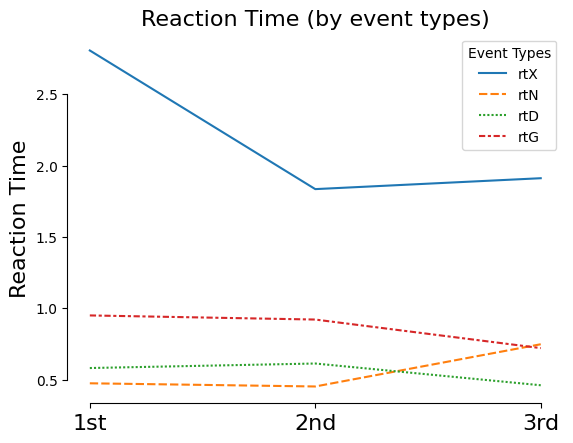

In [9]:
events_rt_plot = {}
events_rt_stat = {}
for event in ['rtX', 'rtN', 'rtD', 'rtG']:
    allrep = []
    allrep_avg_over_maze = []
    for rep in range(3):  # rep or block
        allsub = []
        allsub_avg_over_maze = []
        for subj in group_subjs:
            subset = maze_df.loc[ (maze_df['repetition'] == rep) & (maze_df['subj'] == subj), event]  # repetition or block_summary
            allsub.append(subset.tolist())
            sub_maze_avg = sum(subset)/24
            allsub_avg_over_maze.append(sub_maze_avg)
        #sub_avg_per_event = [sum(sub_list)/len(sub_list) for sub_list in zip(*allsub)]        
        avg_subj_per_rep = sum(allsub_avg_over_maze)/len(group_subjs)
        allrep_avg_over_maze.append(avg_subj_per_rep)
        allrep.append(allsub_avg_over_maze)
    events_rt_plot[event] = allrep_avg_over_maze
    events_rt_stat[event] = allrep

events_rt_stat = pd.DataFrame(events_rt_stat)
# transpose events_rt_stat
events_rt_stat = events_rt_stat.T
# assign column names
events_rt_stat.index = ['rtX', 'rtN', 'rtD', 'rtG']
# assign index names
events_rt_stat.columns = ['1st', '2nd', '3rd']

events_stat_output = pd.DataFrame(index = ['p - X VS N', 'p - X VS D', 'p - X VS G', 'p - N VS D', 'p - N VS G', 'p - D VS G'], columns = ['1st', '2nd', '3rd'])
for rep in ['1st', '2nd', '3rd']:
    events_stat_output[rep]['p - X VS N'] = stats.ttest_rel(events_rt_stat[rep]['rtX'], events_rt_stat[rep]['rtN']).pvalue
    events_stat_output[rep]['p - X VS D'] = stats.ttest_rel(events_rt_stat[rep]['rtX'], events_rt_stat[rep]['rtD']).pvalue
    events_stat_output[rep]['p - X VS G'] = stats.ttest_rel(events_rt_stat[rep]['rtX'], events_rt_stat[rep]['rtG']).pvalue
    events_stat_output[rep]['p - N VS D'] = stats.ttest_rel(events_rt_stat[rep]['rtN'], events_rt_stat[rep]['rtD']).pvalue
    events_stat_output[rep]['p - N VS G'] = stats.ttest_rel(events_rt_stat[rep]['rtN'], events_rt_stat[rep]['rtG']).pvalue
    events_stat_output[rep]['p - D VS G'] = stats.ttest_rel(events_rt_stat[rep]['rtD'], events_rt_stat[rep]['rtG']).pvalue



# save the p value of 4 reaction time for the first, second and third repetition
events_stat_output.to_csv('p value of 4 reaction time for each event type.csv')


# sns.set()
# sns.set_style("white")
a1 = sns.lineplot(data=events_rt_plot)
a1.set_xticks([0, 1, 2], ['1st', '2nd', '3rd'], fontsize = 16)
#a1.set_yticks([0, 0.3, 0.6, 0.9])
a1.set_ylabel("Reaction Time", fontsize = 16)
a1.set_xlabel("")
a1.set_title('Reaction Time (by event types)',  fontsize = 16)
a1.legend(title='Event Types')
sns.despine(trim=True, left=False)
plt.show()

fig = a1.get_figure()
fig.savefig('rt by event types (dif reps).png', dpi = 1000)

# pic 2 set: event rt -- plot event separately by each mazeset/ rep

In [10]:
columns = group_df.columns.tolist()

if 'acc_context_12' in columns:
    if group_df['acc_context_12'].isna().any():
        reaction_times = []
        x = [1,2,3]
        anova_tables = []
        for event in ['rtX', 'rtN', 'rtD', 'rtG']:    
            for block in range(3):
                mean_set = []
                sem_set = []
                block_reactions = []
                for rep in range(3):
                    data = maze_df.loc[ (maze_df['block_summary'] == block) & (maze_df['repetition'] == rep) , event]
                    block_rep_rt = data.tolist()
                    block_reactions.append(block_rep_rt)
                    mean = np.mean(data)
                    sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                    mean_set.append(mean)
                    sem_set.append(sem)
                reaction_times.append(block_reactions)
                plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(block+1) )
                
        
            # Convert nested list to a pandas DataFrame
            data_list = []  # List to accumulate data
        
            for i in range(len(reaction_times)):
                for j in range(len(reaction_times[i])):
                    for k in range(len(reaction_times[i][j])):
                        new_data = {'Block': i+1, 'Repetition': j+1, 'Reaction Time': reaction_times[i][j][k]}
                        data_list.append(new_data)
            
            # Create DataFrame from the accumulated data
            df = pd.DataFrame(data_list)
            
            # Fit the ANOVA model
            model = ols('Q("Reaction Time") ~ C(Block) + C(Repetition) + C(Block):C(Repetition)', data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            anova_tables.append(anova_table)
        
        
            plt.legend(loc='upper right')
            plt.xticks([1,2,3])
            plt.title(event)
            plt.xlabel('repetition') 
            plt.ylabel('reaction time')
            plt.savefig(event + 'rt by event types (dif reps).png', dpi = 1000)
            plt.close()
        
        anova_df = pd.concat(anova_tables, keys=['rtX', 'rtN', 'rtD', 'rtG'])
        anova_df.to_csv('anova_results.csv')

    else:  
        reaction_times = []
        x = [1,2,3]
        anova_tables = []
        for event in ['rtX', 'rtN', 'rtD', 'rtG']:    
            for block in range(4):
                mean_set = []
                sem_set = []
                block_reactions = []
                for rep in range(3):
                    data = maze_df.loc[ (maze_df['block_summary'] == block) & (maze_df['repetition'] == rep) , event]
                    block_rep_rt = data.tolist()
                    block_reactions.append(block_rep_rt)
                    mean = np.mean(data)
                    sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                    mean_set.append(mean)
                    sem_set.append(sem)
                reaction_times.append(block_reactions)
                plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(block+1) )
    
            # Convert nested list to a pandas DataFrame
            data_list = []  # List to accumulate data
    
            for i in range(len(reaction_times)):
                for j in range(len(reaction_times[i])):
                    for k in range(len(reaction_times[i][j])):
                        new_data = {'Block': i+1, 'Repetition': j+1, 'Reaction Time': reaction_times[i][j][k]}
                        data_list.append(new_data)
            
            # Create DataFrame from the accumulated data
            df = pd.DataFrame(data_list)
    
            # Fit the ANOVA model
            model = ols('Q("Reaction Time") ~ C(Block) + C(Repetition) + C(Block):C(Repetition)', data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            anova_tables.append(anova_table)
    
            
    
            plt.legend(loc='upper right')
            plt.xticks([1,2,3])
            plt.title(event)
            plt.xlabel('repetition') 
            plt.ylabel('reaction time')
            plt.savefig(event + 'rt by event types (dif reps).png', dpi = 1000)
            plt.close()
        
    
        anova_df = pd.concat(anova_tables, keys=['rtX', 'rtN', 'rtD', 'rtG'])
        anova_df.to_csv('anova_results.csv')

if 'acc_context_12' not in columns:
    reaction_times = []
    x = [1,2,3]
    anova_tables = []
    for event in ['rtX', 'rtN', 'rtD', 'rtG']:    
        for block in range(3):
            mean_set = []
            sem_set = []
            block_reactions = []
            for rep in range(3):
                data = maze_df.loc[ (maze_df['block_summary'] == block) & (maze_df['repetition'] == rep) , event]
                block_rep_rt = data.tolist()
                block_reactions.append(block_rep_rt)
                mean = np.mean(data)
                sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                mean_set.append(mean)
                sem_set.append(sem)
            reaction_times.append(block_reactions)
            plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(block+1) )
            

        # Convert nested list to a pandas DataFrame
        data_list = []  # List to accumulate data

        for i in range(len(reaction_times)):
            for j in range(len(reaction_times[i])):
                for k in range(len(reaction_times[i][j])):
                    new_data = {'Block': i+1, 'Repetition': j+1, 'Reaction Time': reaction_times[i][j][k]}
                    data_list.append(new_data)
        
        # Create DataFrame from the accumulated data
        df = pd.DataFrame(data_list)
        
        # Fit the ANOVA model
        model = ols('Q("Reaction Time") ~ C(Block) + C(Repetition) + C(Block):C(Repetition)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_tables.append(anova_table)


        plt.legend(loc='upper right')
        plt.xticks([1,2,3])
        plt.title(event)
        plt.xlabel('repetition') 
        plt.ylabel('reaction time')
        plt.savefig(event + 'rt by event types (dif reps).png', dpi = 1000)
        plt.close()

    anova_df = pd.concat(anova_tables, keys=['rtX', 'rtN', 'rtD', 'rtG'])
    anova_df.to_csv('anova_results.csv')


# pic 3: quiz accuracy for each rep

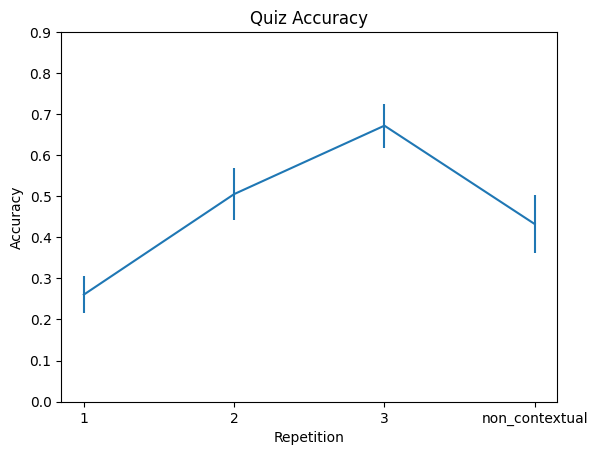

In [11]:
columns = group_df.columns.tolist()

if 'acc_context_12' in columns:
    if group_df['acc_context_12'].isna().any():
        x = ['1', '2', '3', 'non_contextual']
        mean_set = []
        sem_set = []
        for set in [[1,4,7], [2,5,8], [3,6,9]]: 
            data_group = []
            for idx in range(len(set)):        
                col = 'acc_context_' + str(set[idx])
                data = group_df[col]
                data_group.append(data)
            mean = np.mean(data_group)
            sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
            mean_set.append(mean)
            sem_set.append(sem)
        
        data_group_non_context = []
        for idx in range(1,4):
            col = 'acc_noncontext_' + str(idx)
            data = group_df[col]
            data_group_non_context.append(data)
        mean = np.mean(data_group_non_context)
        sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
        mean_set.append(mean)
        sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set )
    else:
        x = ['1', '2', '3', 'non_contextual']
        mean_set = []
        sem_set = []
        for set in [[1,4,7,10], [2,5,8,11], [3,6,9,12]]: 
            data_group = []
            for idx in range(len(set)):        
                col = 'acc_context_' + str(set[idx])
                data = group_df[col]
                data_group.append(data)
            mean = np.mean(data_group)
            sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
            mean_set.append(mean)
            sem_set.append(sem)
    
        data_group_non_context = []
        for idx in range(1,5):
            col = 'acc_noncontext_' + str(idx)
            data = group_df[col]
            data_group_non_context.append(data)
        mean = np.mean(data_group_non_context)
        sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
        mean_set.append(mean)
        sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set )


if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    mean_set = []
    sem_set = []
    for set in [[1,4,7], [2,5,8], [3,6,9]]: 
        data_group = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            data = group_df[col]
            data_group.append(data)
        mean = np.mean(data_group)
        sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
        mean_set.append(mean)
        sem_set.append(sem)
    
    data_group_non_context = []
    for idx in range(1,4):
        col = 'acc_noncontext_' + str(idx)
        data = group_df[col]
        data_group_non_context.append(data)
    mean = np.mean(data_group_non_context)
    sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
    mean_set.append(mean)
    sem_set.append(sem)
    plt.errorbar(x, mean_set, yerr=sem_set )

plt.title('Quiz Accuracy')
plt.xlabel('Repetition') 
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylabel('Accuracy')
plt.savefig('quiz accuracy (by rep).png', dpi = 1000)
plt.show()
plt.close()

# pic 4: quiz accuracy for every block

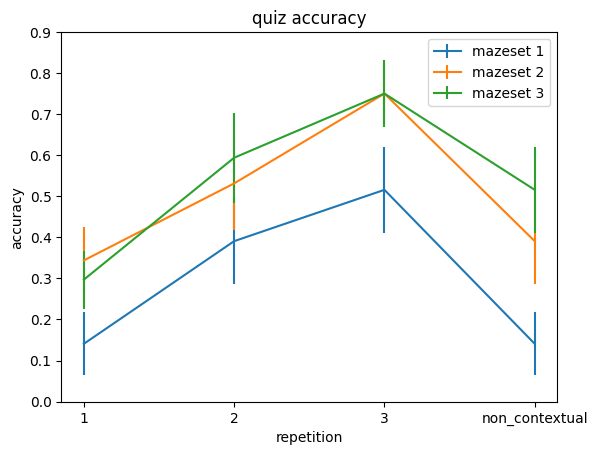

In [12]:
columns = group_df.columns.tolist()

if 'acc_context_12' in columns:
    if group_df['acc_context_12'].isna().any():
        x = ['1', '2', '3', 'non_contextual']
        count = 1
        for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
            mean_set = []
            sem_set = []
            for idx in range(len(set)):        
                col = 'acc_context_' + str(set[idx])
                if idx == len(set):
                    col = 'acc_noncontext_' + str(set[idx])
                data = group_df[col]
                mean = np.mean(data)
                sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                mean_set.append(mean)
                sem_set.append(sem)
            plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
            count += 1

    else:
        x = ['1', '2', '3', 'non_contextual']
        count = 1
        for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3], [10,11,12,4]]:
            mean_set = []
            sem_set = []
            for idx in range(len(set)):        
                col = 'acc_context_' + str(set[idx])
                if idx == len(set):
                    col = 'acc_noncontext_' + str(set[idx])
                data = group_df[col]
                mean = np.mean(data)
                sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                mean_set.append(mean)
                sem_set.append(sem)
            plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
            count += 1
if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    count = 1
    for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            if idx == len(set):
                col = 'acc_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
        count += 1



plt.legend(loc='upper right')
plt.title('quiz accuracy')
plt.xlabel('repetition') 
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylabel('accuracy')
plt.show()
plt.savefig('quiz accuracy (by mazeset).png', dpi = 200)
plt.close()

# pic 5: quiz precision for rep

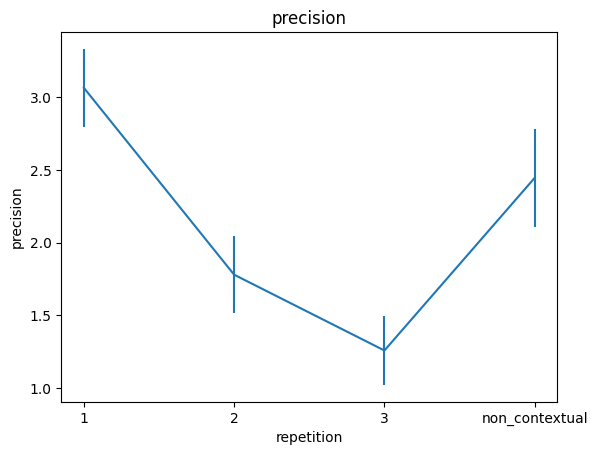

In [13]:
columns = group_df.columns.tolist()

if 'acc_context_12'  in columns:
    if group_df['acc_context_12'].isna().any():
        x = ['1', '2', '3', 'non_contextual']
        mean_set = []
        sem_set = []
        for set in [[1,4,7], [2,5,8], [3,6,9]]:
            data_group = []
            for idx in range(len(set)):        
                col = 'dist_context_' + str(set[idx])
                data = group_df[col]
                data_group.append(data)
            mean = np.mean(data_group)
            sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
            mean_set.append(mean)
            sem_set.append(sem)
    
        data_group_non_context = []
        for idx in range(1,4):
            col = 'dist_noncontext_' + str(idx)
            data = group_df[col]
            data_group_non_context.append(data)
        mean = np.mean(data_group_non_context)
        sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
        mean_set.append(mean)
        sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set )


    else:
        x = ['1', '2', '3', 'non_contextual']
        mean_set = []
        sem_set = []
        for set in [[1,4,7,10], [2,5,8,11], [3,6,9,12]]:
            data_group = []
            for idx in range(len(set)):        
                col = 'dist_context_' + str(set[idx])
                data = group_df[col]
                data_group.append(data)
            mean = np.mean(data_group)
            sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
            mean_set.append(mean)
            sem_set.append(sem)
    
        data_group_non_context = []
        for idx in range(1,4):
            col = 'dist_noncontext_' + str(idx)
            data = group_df[col]
            data_group_non_context.append(data)
        mean = np.mean(data_group_non_context)
        sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
        mean_set.append(mean)
        sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set )
    
if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    mean_set = []
    sem_set = []
    for set in [[1,4,7], [2,5,8], [3,6,9]]:
        data_group = []
        for idx in range(len(set)):        
            col = 'dist_context_' + str(set[idx])
            data = group_df[col]
            data_group.append(data)
        mean = np.mean(data_group)
        sem = np.std(data_group, ddof=1) / np.sqrt(np.size(data_group))
        mean_set.append(mean)
        sem_set.append(sem)

    data_group_non_context = []
    for idx in range(1,4):
        col = 'dist_noncontext_' + str(idx)
        data = group_df[col]
        data_group_non_context.append(data)
    mean = np.mean(data_group_non_context)
    sem = np.std(data_group_non_context, ddof=1) / np.sqrt(np.size(data_group_non_context))
    mean_set.append(mean)
    sem_set.append(sem)
    plt.errorbar(x, mean_set, yerr=sem_set )

plt.title('precision')
plt.xlabel('repetition') 
plt.ylabel('precision')
plt.savefig('precision (by rep).png', dpi = 200)
plt.show()
plt.close()

# pic 6: quiz precision for each block

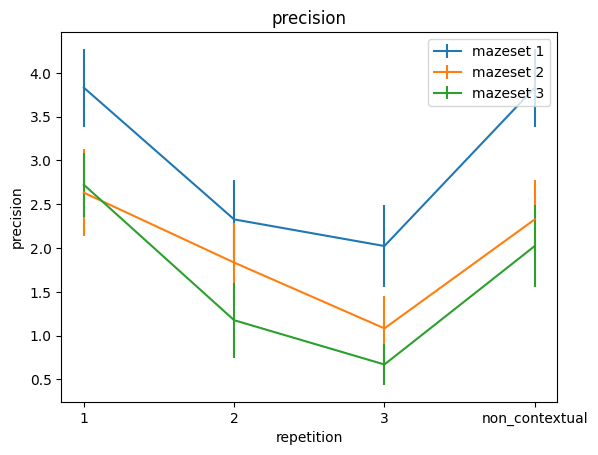

In [14]:
columns = group_df.columns.tolist()
if 'acc_context_12' in columns:
    if group_df['acc_context_12'].isna().any():
        x = ['1', '2', '3', 'non_contextual']
        count = 1
        for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
            mean_set = []
            sem_set = []
            for idx in range(len(set)):        
                col = 'dist_context_' + str(set[idx])
                if idx == len(set):
                    col = 'dist_noncontext_' + str(set[idx])
                data = group_df[col]
                mean = np.mean(data)
                sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                mean_set.append(mean)
                sem_set.append(sem)
            plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
            count += 1

    else:
        x = ['1', '2', '3', 'non_contextual']
        count = 1
        for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3],[10,11,12,4]]:
            mean_set = []
            sem_set = []
            for idx in range(len(set)):        
                col = 'dist_context_' + str(set[idx])
                if idx == len(set):
                    col = 'dist_noncontext_' + str(set[idx])
                data = group_df[col]
                mean = np.mean(data)
                sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
                mean_set.append(mean)
                sem_set.append(sem)
            plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
            count += 1
if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    count = 1
    for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'dist_context_' + str(set[idx])
            if idx == len(set):
                col = 'dist_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
        count += 1


plt.legend(loc='upper right')
plt.title('precision')
plt.xlabel('repetition') 
plt.ylabel('precision')
plt.show()
plt.savefig('precision (by mazeset).png', dpi = 200)
plt.close()

# FOR MEMORY CONFERENCE ************ box plot that shows improvement across mazes (contextual quizzes) (Serigne)

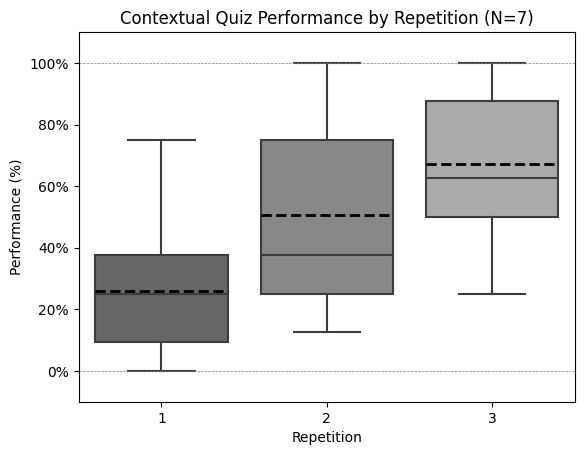

In [15]:
# Filter the DataFrame to only include columns that start with "acc_context_"
acc_cols = group_df.filter(regex=r'acc_context_\d+')

# Melt the data into a "long" format where all the scores are stacked into a single column
melted_df = pd.melt(group_df, id_vars=["id"], value_name="performance", var_name="variable", value_vars=acc_cols)

# Extract the repetition number from the block number
melted_df["repetition"] = melted_df["variable"].str.extract(r'acc_context_(\d+)', expand=False).fillna(-1).astype(int)
melted_df["repetition"] = (melted_df["repetition"] - 1) % 3 + 1

exclude_values = ['acc_context_10','acc_context_11','acc_context_12']

melted_df = melted_df[~melted_df['variable'].isin(exclude_values)]

custom_palette = ['#666666', '#888888', '#AAAAAA']

sns.set_palette(custom_palette)

# Create a violin plot of all subjects' performance over repetition
sns.boxplot(x="repetition", y="performance", data=melted_df, showmeans=True,showfliers = False ,meanline=True, meanprops={"linewidth": 2, "color": "black"})

# # Add a line to show the average performance across subjects for each repetition
# average_df = melted_df.groupby("repetition").mean(numeric_only=True).reset_index()

# average_df["repetition"] = (average_df["repetition"] - 1)
# sns.lineplot(x="repetition", y="performance", data=average_df, color="black", label="Average")

# Set the y-axis labels to be in percentage format
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))  # Multiply by 100 and remove decimals

ax.axhline(1, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.yaxis.grid(False)


# Set the plot title and labels
plt.title("Contextual Quiz Performance by Repetition (N=7)")
plt.xlabel("Repetition")
plt.ylabel("Performance (%)")
plt.ylim(-.1,1.1)

#plt.show()
# Show the plot
plt.savefig('Contextual Quiz Performance by Repetition - patients(box - dotted mean, solid median).png', dpi = 1000)


# box plot that shows improvement across mazes (non-contextual quizzes)

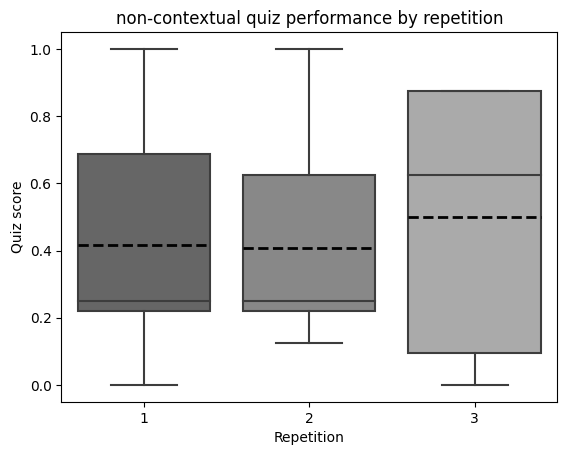

<Figure size 640x480 with 0 Axes>

In [16]:
# Filter the DataFrame to only include columns that start with "acc_context_"
acc_cols = group_df.filter(regex=r'acc_noncontext_\d+')

# Melt the data into a "long" format where all the scores are stacked into a single column
melted_df = pd.melt(group_df, id_vars=["id"], value_name="performance", var_name="variable", value_vars=acc_cols)

# Extract the repetition number from the block number
melted_df["repetition"] = melted_df["variable"].str.extract(r'acc_noncontext_(\d+)', expand=False).fillna(-1).astype(int)
melted_df["repetition"] = (melted_df["repetition"] - 1) % 3 + 1

# Create a violin plot of all subjects' performance over repetition
sns.boxplot(x="repetition", y="performance", data=melted_df, showmeans=True, meanline=True, meanprops={"linewidth": 2, "color": "black"})


# # Add a line to show the average performance across subjects for each repetition
# average_df = melted_df.groupby("repetition").mean(numeric_only=True).reset_index()
# average_df["repetition"] = (average_df["repetition"] - 1)
# sns.lineplot(x="repetition", y="performance", data=average_df, color="black", label="Average")

# Set the plot title and labels
plt.title("non-contextual quiz performance by repetition")
plt.xlabel("Repetition")
plt.ylabel("Quiz score")

plt.show()
# Show the plot
plt.savefig('non-Contextual quiz performance by repetition (box).png', dpi = 200)

# Line plot that shows improvement across repetition (split between blocks)

# event rt

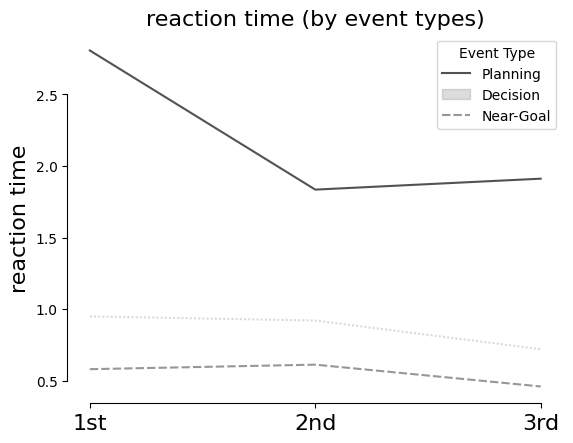

In [17]:
events_rt_plot = {}
events_rt_stat = {}
for event in ['rtX', 'rtD', 'rtG']:
    allrep = []
    allrep_avg_over_maze = []
    for rep in range(3):  # rep or block
        allsub = []
        allsub_avg_over_maze = []
        for subj in group_subjs:
            subset = maze_df.loc[ (maze_df['repetition'] == rep) & (maze_df['subj'] == subj), event]  # repetition or block_summary
            allsub.append(subset.tolist())
            sub_maze_avg = sum(subset)/24
            allsub_avg_over_maze.append(sub_maze_avg)
        #sub_avg_per_event = [sum(sub_list)/len(sub_list) for sub_list in zip(*allsub)]        
        avg_subj_per_rep = sum(allsub_avg_over_maze)/len(group_subjs)
        allrep_avg_over_maze.append(avg_subj_per_rep)
        allrep.append(allsub_avg_over_maze)
    events_rt_plot[event] = allrep_avg_over_maze
    events_rt_stat[event] = allrep

events_rt_stat = pd.DataFrame(events_rt_stat)
# transpose events_rt_stat
events_rt_stat = events_rt_stat.T
# assign column names
events_rt_stat.index = ['rtX',  'rtD', 'rtG']
# assign index names
events_rt_stat.columns = ['1st', '2nd', '3rd']

events_stat_output = pd.DataFrame(index = ['p - X VS N', 'p - X VS D', 'p - X VS G', 'p - N VS D', 'p - N VS G', 'p - D VS G'], columns = ['1st', '2nd', '3rd'])
for rep in ['1st', '2nd', '3rd']:
    events_stat_output[rep]['p - X VS D'] = stats.ttest_rel(events_rt_stat[rep]['rtX'], events_rt_stat[rep]['rtD']).pvalue
    events_stat_output[rep]['p - X VS G'] = stats.ttest_rel(events_rt_stat[rep]['rtX'], events_rt_stat[rep]['rtG']).pvalue
    events_stat_output[rep]['p - D VS G'] = stats.ttest_rel(events_rt_stat[rep]['rtD'], events_rt_stat[rep]['rtG']).pvalue



# save the p value of 4 reaction time for the first, second and third repetition
events_stat_output.to_csv('p value of 4 reaction time for each event type.csv')


# modify color palette to shades of grey
my_palette = sns.color_palette("Greys_r", 3)

a1 = sns.lineplot(data=events_rt_plot, palette=my_palette)
a1.set_xticks([0, 1, 2], ['1st', '2nd', '3rd'], fontsize = 16)
#a1.set_yticks([0, 0.3, 0.6, 0.9])
a1.set_ylabel("reaction time", fontsize = 16)
a1.set_xlabel("")
a1.set_title('reaction time (by event types)',  fontsize = 16)
legend_labels = {'rtX': 'Planning', 'rtD': 'Decision', 'rtG': 'Near-Goal'}
a1.legend(title='Event Type', labels=[legend_labels[label] for label in events_rt_plot.keys()])
sns.despine(trim=True, left=False)

fig = a1.get_figure()
plt.show()
fig.savefig('rt by event types (dif reps).png', dpi = 200)

# normalize distance travelled per maze

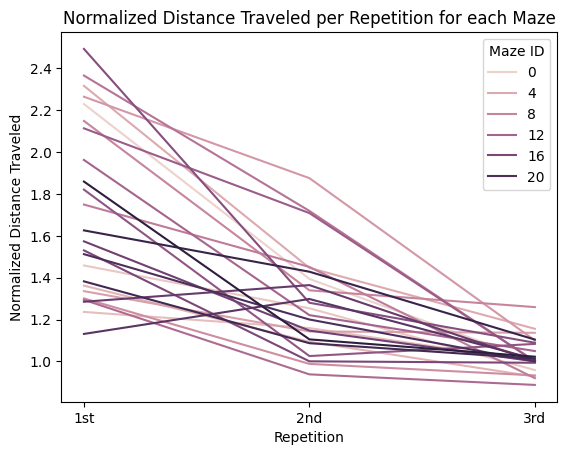

In [18]:
# create a new column to store the distance traveled in the third repetition for each subject and maze
maze_df['dist_traveled_3'] = maze_df.loc[maze_df['repetition'] == 2, 'dist_traveled']

# normalize distance traveled by dividing by distance traveled in the third repetition
maze_df['normalized_dist'] = maze_df.groupby(['subj', 'maze_id'])['dist_traveled'].transform(
    lambda x: x / x.iloc[-1]
)

# plot the normalized distance traveled per repetition for each maze
sns.lineplot(data=maze_df, x='repetition', y='normalized_dist', hue='maze_id', errorbar=None)

# set plot title and axis labels
plt.title('Normalized Distance Traveled per Repetition for each Maze')
plt.xlabel('Repetition')
plt.ylabel('Normalized Distance Traveled')

plt.legend(title="Maze ID")

# set x-ticks and labels
plt.xticks([0, 1, 2], ['1st', '2nd', '3rd'])

# show the plot
plt.savefig('Normalized Distance Traveled per Repetition for each Maze.png', dpi = 1000)

plt.show()


# plot accuracy for every mazeset

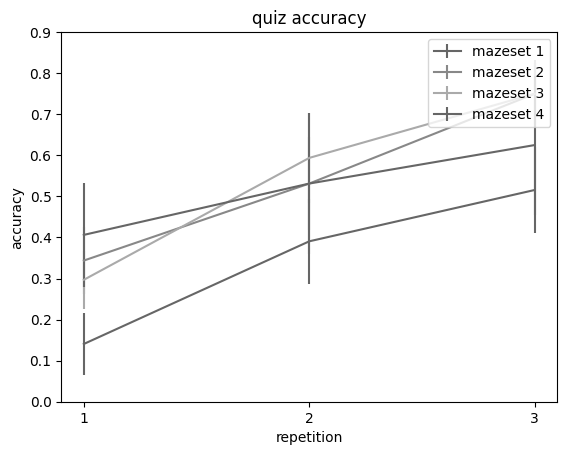

In [19]:
columns = group_df.columns.tolist()

if 'acc_context_12' in columns:
    x = ['1', '2', '3']
    count = 1
    for set in [[1,2,3], [4,5,6], [7,8,9], [10,11,12]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            if idx == len(set):
                col = 'acc_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
        count += 1
if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    count = 1
    for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            if idx == len(set):
                col = 'acc_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'mazeset ' + str(count) )
        count += 1



plt.legend(loc='upper right')
plt.title('quiz accuracy')
plt.xlabel('repetition') 
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylabel('accuracy')
#plt.savefig('quiz accuracy (by mazeset).png', dpi = 200)
plt.show()
plt.close()

# plot accuracy for every mazeset (Serigne)

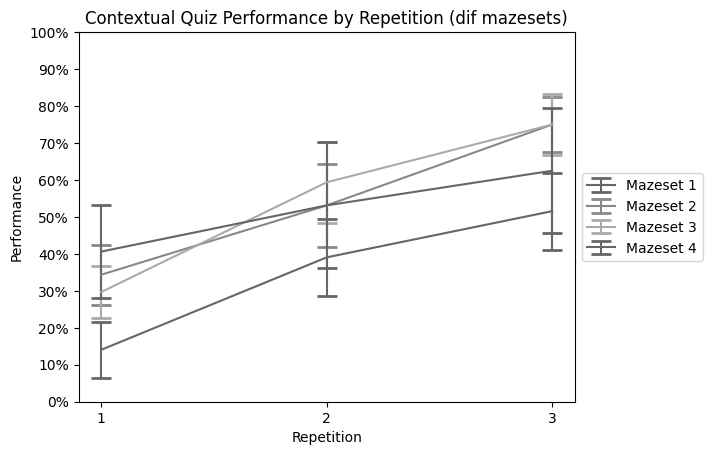

In [20]:
columns = group_df.columns.tolist()

if 'acc_context_12' in columns:
    x = ['1', '2', '3']
    count = 1
    for set in [[1,2,3], [4,5,6], [7,8,9], [10,11,12]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            if idx == len(set):
                col = 'acc_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'Mazeset ' + str(count), capsize=7, capthick=2)
        count += 1
if 'acc_context_12' not in columns:
    x = ['1', '2', '3', 'non_contextual']
    count = 1
    for set in [[1,2,3,1], [4,5,6,2], [7,8,9,3]]:
        mean_set = []
        sem_set = []
        for idx in range(len(set)):        
            col = 'acc_context_' + str(set[idx])
            if idx == len(set):
                col = 'acc_noncontext_' + str(set[idx])
            data = group_df[col]
            mean = np.mean(data)
            sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
            mean_set.append(mean)
            sem_set.append(sem)
        plt.errorbar(x, mean_set, yerr=sem_set, label = 'Mazeset ' + str(count), capsize =7, capthick=2)
        count += 1

# Format the y-axis labels as percentages
formatter = FuncFormatter(lambda y, _: f'{y:.0%}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.title('Contextual Quiz Performance by Repetition (dif mazesets)')
plt.grid(False)
plt.xlabel('Repetition') 
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylabel('Performance')
plt.savefig('Contextual Quiz Performance by Repetition (dif mazesets).png',bbox_inches='tight', dpi = 1000)
plt.show()
plt.close()

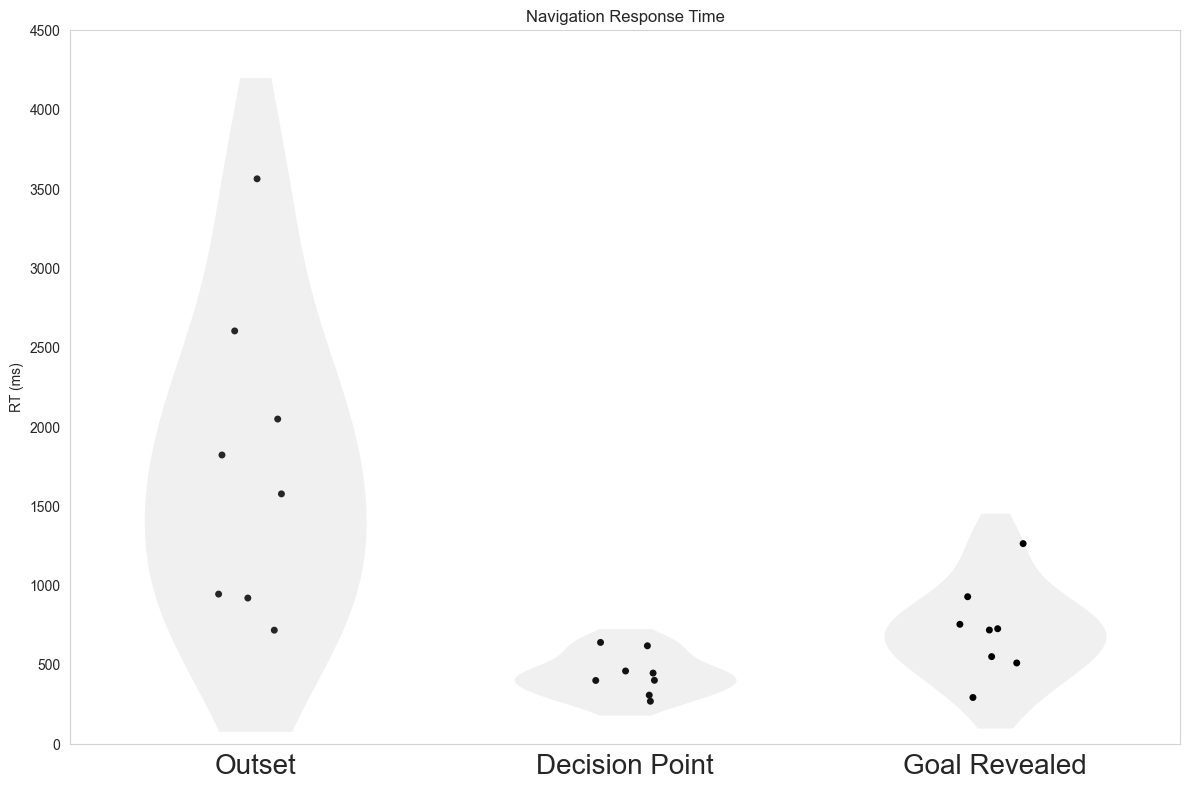

In [21]:
# Subset the DataFrame to include only the relevant columns
subset_df = (group_df[['rtX', 'rtD', 'rtG']])*1000

# Set the seaborn style with gray grid
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'lightgray'})

# Create the violin plot with no inner elements
plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=subset_df, inner=None, scale="width", color = '#F0F0F0', cut = 1, linewidth = 0, bw_method = 'silverman', width = 0.6)  # Use inner=None

# Plot individual data points for each participant
sns.stripplot(data=subset_df, jitter=True, palette='dark:black', alpha=1)

ax.set_xticklabels(['Outset','Decision Point','Goal Revealed'])
ax.tick_params(axis = 'x',labelsize = 20)
ax.grid(False)
plt.title("Navigation Response Time")
plt.ylabel("RT (ms)")
plt.ylim(0,4500)
# Show the plot
plt.tight_layout()
plt.savefig('Violin Plot - Navigation Response Time', dpi = 1000)
plt.show()


# RT Violin Plots for Outset, Neutral, Decision Points

      subj  repetition          rtX
0     DA17           0  1019.177056
1     DA17           1   954.824228
2     DA17           2   866.378519
3     DA18           0   779.918904
4     DA18           1   715.240736
5     DA18           2   662.672358
6   DA19_1           0  1719.012325
7   DA19_1           1  1372.062157
8   DA19_1           2  1655.223245
9   DA19_2           0   902.537090
10  DA19_2           1   939.407242
11  DA19_2           2   923.593698
12    DA22           0  1712.692632
13    DA22           1  1515.085106
14    DA22           2  1462.567789
15    DA23           0  3078.083635
16    DA23           1  1670.800398
17    DA23           2  1709.194390
18    DA30           0  2202.169112
19    DA30           1  2630.301199
20    DA30           2  2305.883819
21   IR103           0  2145.415500
22   IR103           1  1489.834325
23   IR103           2  1533.702850


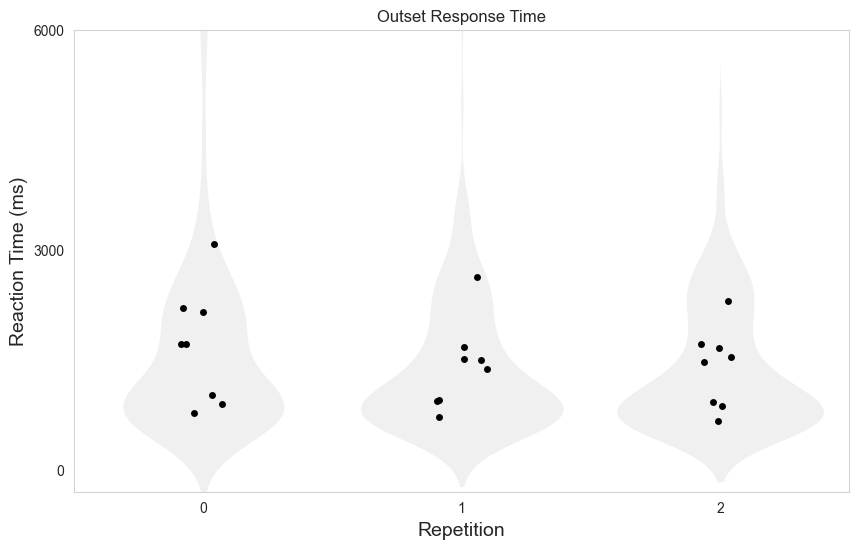

In [22]:
subset_df = (maze_df[['subj','repetition','block_summary','rtX', 'rtD', 'rtN']])

filtered_df = subset_df[subset_df['block_summary'] < 3]

# Multiply the 'rtX' column by 1000 to convert seconds to milliseconds using .loc
filtered_df.loc[:, 'rtX'] = filtered_df['rtX'] * 1000

# Define a threshold for outlier detection (e.g., values outside 2 IQR)
iqr = filtered_df['rtX'].quantile(0.75) - filtered_df['rtX'].quantile(0.25)
threshold = 5 * iqr

# Filter the DataFrame to exclude outliers in 'rtX' 
filtered_df = filtered_df[filtered_df['rtX'] <= threshold]
# Filter the DataFrame to exclude certain blocks in IR103 and DA23 
filtered_df = filtered_df[~((filtered_df['subj'] == 'IR103') & filtered_df['block_summary'].isin([0,3]))]
filtered_df = filtered_df[~((filtered_df['subj'] == 'DA23') & filtered_df['block_summary'].isin([0,3]))]

# Calculate the mean reaction time of each subject
mean_rt = filtered_df.groupby(['subj', 'repetition'])['rtX'].mean().reset_index()

print(mean_rt)

# Create the violin plot for 'rtX' (excluding outliers)
plt.figure(figsize=(10, 6))  # Set the plot size
ax = sns.violinplot(data=filtered_df, x='repetition', y='rtX', linewidth = 0,inner=None, color = '#F0F0F0', label='rtX')

# Set the fontsize for the x-axis and y-axis labels
plt.xlabel('Repetition', fontsize=14)  # Adjust the fontsize as needed
plt.ylabel('Reaction Time (ms)', fontsize=14)  # Adjust the fontsize as needed
plt.title('Outset Response Time')
plt.ylim(-300,6000)

# Hide grid lines
ax.yaxis.grid(False)

# Plot points for the mean reaction time of each subject on each violin using a stripplot
sns.stripplot(data=mean_rt, x='repetition', y='rtX', color='black', size=5, ax=ax, jitter=True, alpha = 1)

tick_positions = [0, 3000, 6000]  # Set the desired tick positions
tick_labels = [str(tp) for tp in tick_positions]  # Convert tick positions to strings

ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

plt.savefig('Violin Plot - Outset Response Time', dpi = 1000)

# Show the plot
plt.show()


      subj  repetition         rtN
0     DA17           0  285.726199
1     DA17           1  277.005054
2     DA17           2  244.649553
3     DA18           0  275.085606
4     DA18           1  254.681223
5     DA18           2  231.373093
6   DA19_1           0  423.757254
7   DA19_1           1  385.267886
8   DA19_1           2  381.444059
9   DA19_2           0  360.136542
10  DA19_2           1  350.363283
11  DA19_2           2  327.419017
12    DA22           0  415.860616
13    DA22           1  350.066421
14    DA22           2  350.708951
15    DA23           0  377.253218
16    DA23           1  383.750293
17    DA23           2  358.394743
18    DA30           0  600.392753
19    DA30           1  658.750362
20    DA30           2  630.397938
21   IR103           0  362.653074
22   IR103           1  341.123758
23   IR103           2  317.474918


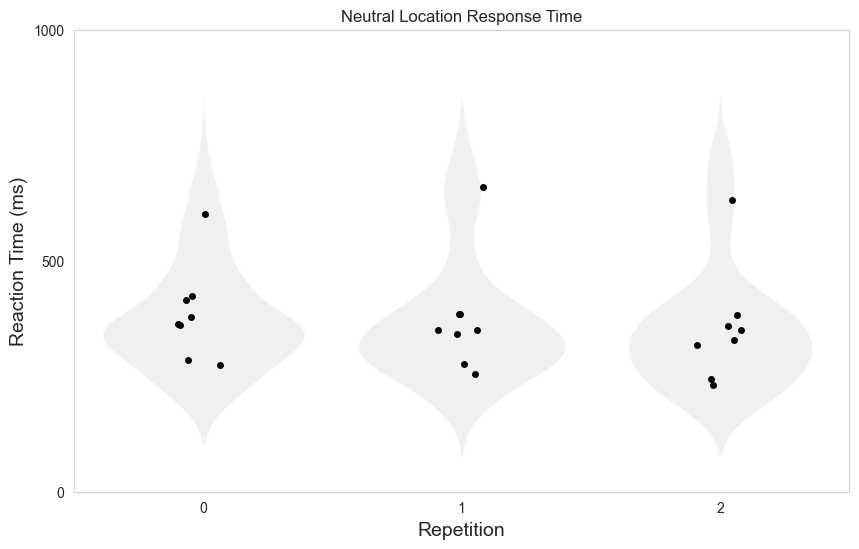

In [23]:
subset_df = (maze_df[['subj','repetition','block_summary','rtX', 'rtD', 'rtN']])

filtered_df = subset_df[subset_df['block_summary'] < 3]

# Multiply the 'rtN' column by 1000 to convert seconds to milliseconds using .loc
filtered_df.loc[:, 'rtN'] = filtered_df['rtN'] * 1000

# Define a threshold for outlier detection (e.g., values outside 2 IQR)
iqr = filtered_df['rtN'].quantile(0.75) - filtered_df['rtN'].quantile(0.25)
threshold = 5 * iqr

# Filter the DataFrame to exclude outliers in 'rtX' 
filtered_df = filtered_df[filtered_df['rtN'] <= threshold]
# Filter the DataFrame to exclude certain blocks in IR103 and DA23 
filtered_df = filtered_df[~((filtered_df['subj'] == 'IR103') & filtered_df['block_summary'].isin([0,3]))]
filtered_df = filtered_df[~((filtered_df['subj'] == 'DA23') & filtered_df['block_summary'].isin([0,3]))]

# Calculate the mean reaction time of each subject
mean_rt = filtered_df.groupby(['subj', 'repetition'])['rtN'].mean().reset_index()

print(mean_rt)

# # Create the violin plot for 'rtN' (excluding outliers)
plt.figure(figsize=(10, 6))  # Set the plot size
ax = sns.violinplot(data=filtered_df, x='repetition', y='rtN', color = '#F0F0F0',linewidth = 0,inner=None, label='rtN')

# Set the fontsize for the x-axis and y-axis labels
plt.xlabel('Repetition', fontsize=14)  # Adjust the fontsize as needed
plt.ylabel('Reaction Time (ms)', fontsize=14)  # Adjust the fontsize as needed
plt.title('Neutral Location Response Time')
plt.ylim(0,1000)

# Hide grid lines
ax.yaxis.grid(False)

tick_positions = [0, 500, 1000]  # Set the desired tick positions
tick_labels = [str(tp) for tp in tick_positions]  # Convert tick positions to strings

ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)


# Plot points for the mean reaction time of each subject on each violin using a stripplot
sns.stripplot(data=mean_rt, x='repetition', y='rtN', color='black', size=5, ax=ax, jitter=True, alpha = 1)

plt.savefig('Violin Plot - Neutral Response Time', dpi = 1000)


# Show the plot
plt.show()

      subj  repetition         rtD
0     DA17           0  316.646336
1     DA17           1  295.568211
2     DA17           2  239.016643
3     DA18           0  303.362451
4     DA18           1  268.348435
5     DA18           2  237.465983
6   DA19_1           0  494.416146
7   DA19_1           1  427.536562
8   DA19_1           2  401.195099
9   DA19_2           0  414.711158
10  DA19_2           1  388.944326
11  DA19_2           2  364.498914
12    DA22           0  442.974457
13    DA22           1  398.136772
14    DA22           2  312.272070
15    DA23           0  485.628735
16    DA23           1  418.596637
17    DA23           2  465.721752
18    DA30           0  836.074854
19    DA30           1  763.769590
20    DA30           2  767.449953
21   IR103           0  331.617300
22   IR103           1  312.442214
23   IR103           2  279.975175


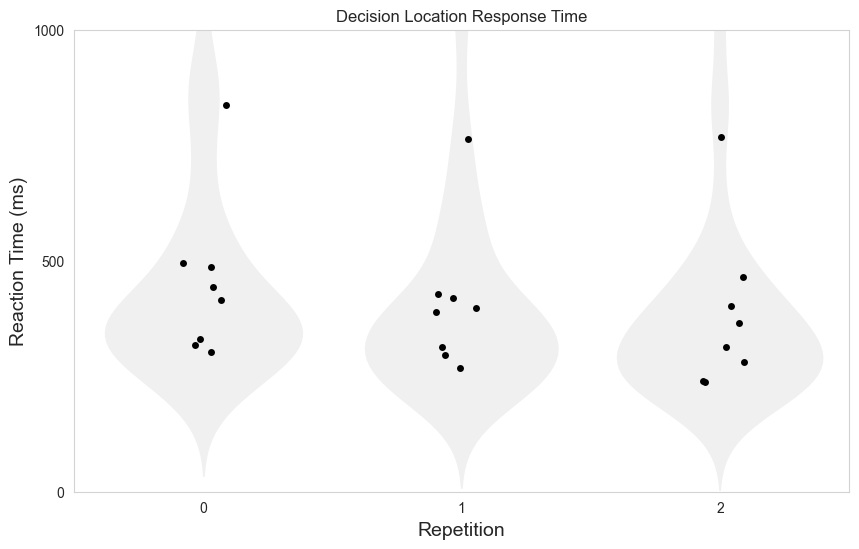

In [24]:
subset_df = (maze_df[['subj','repetition','block_summary','rtX', 'rtD', 'rtN']])

filtered_df = subset_df[subset_df['block_summary'] < 3]

# Multiply the 'rtD' column by 1000 to convert seconds to milliseconds using .loc
filtered_df.loc[:, 'rtD'] = filtered_df['rtD'] * 1000

# Define a threshold for outlier detection (e.g., values outside 2 IQR)
iqr = filtered_df['rtD'].quantile(0.75) - filtered_df['rtD'].quantile(0.25)
threshold = 5 * iqr

# Filter the DataFrame to exclude outliers in 'rtX' 
filtered_df = filtered_df[filtered_df['rtD'] <= threshold]
# Filter the DataFrame to exclude certain blocks in IR103 and DA23 
filtered_df = filtered_df[~((filtered_df['subj'] == 'IR103') & filtered_df['block_summary'].isin([0,3]))]
filtered_df = filtered_df[~((filtered_df['subj'] == 'DA23') & filtered_df['block_summary'].isin([0,3]))]

# Calculate the mean reaction time of each subject
mean_rt = filtered_df.groupby(['subj', 'repetition'])['rtD'].mean().reset_index()

print(mean_rt)

# Create the violin plot for 'rtD' (excluding outliers)
plt.figure(figsize=(10, 6))  # Set the plot size
ax = sns.violinplot(data=filtered_df, x='repetition', y='rtD', color = '#F0F0F0',linewidth = 0,inner=None, label='rtD')

# Set the fontsize for the x-axis and y-axis labels
plt.xlabel('Repetition', fontsize=14)  # Adjust the fontsize as needed
plt.ylabel('Reaction Time (ms)', fontsize=14)  # Adjust the fontsize as needed
plt.title('Decision Location Response Time')
plt.ylim(0,1000)

# Hide grid lines
ax.yaxis.grid(False)

tick_positions = [0, 500, 1000]  # Set the desired tick positions
tick_labels = [str(tp) for tp in tick_positions]  # Convert tick positions to strings

ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Plot points for the mean reaction time of each subject on each violin using a stripplot
sns.stripplot(data=mean_rt, x='repetition', y='rtD', color='black', size=5, ax=ax, jitter=True, alpha = 1)

plt.savefig('Violin Plot - Decision Response Time', dpi = 1000)


# Show the plot
plt.show()